# AOC2022

## Day 24 / Part 2 / Blizzard Basin

Problem Description: https://adventofcode.com/2022/day/24#part2

Input: [Example](aoc2022_day24_example.txt)

In [1]:
%load_ext pycodestyle_magic
%pycodestyle_on

In [2]:
"""Solution for AOC2022, day 24, part 2."""
import logging
import sys
from matplotlib import pyplot as plt
import numpy as np

from common.datastructs import Graph
from common.algorithms import find_shortest_paths

LOGGER = logging.getLogger(__name__)

# show/hide overview
SHOW_OVERVIEW = True
# show/hide debug logs
SHOW_DEBUG_LOG = False
# set input file
INPUT_FILE = "aoc2022_day24_example.txt"

In [3]:
GUESS_ON_MAX_STEPS_NEEDED_TO_CROSS_VALEY = 300

In [4]:
class Simple2DGrid(Graph):
    """Class representing a simple 2D graph."""
    valley_shape = ()
    valleys = {}
    nodes = []

    def __init__(self, valley_shape, blizzards, from_move, to_move=None):
        if to_move is None:
            to_move = from_move
            from_move = 0

        self.valley_shape = valley_shape
        self.from_move = from_move
        self.to_move = to_move
        self.moves = to_move - from_move
        inner_v_shape = (
            self.valley_shape[0] - 2,
            self.valley_shape[1] - 2
        )
        for move in range(self.from_move, self.to_move+1):
            self.valleys[move] = np.zeros(self.valley_shape)
            self.valleys[move][:, 0] = 1
            self.valleys[move][0, 2:] = 1
            self.valleys[move][:, -1] = 1
            self.valleys[move][-1, :-2] = 1
            for char, [y_pos, x_pos] in blizzards:
                if char == "<":
                    x_pos = 1 + (((x_pos-1) - move) % inner_v_shape[1])
                if char == ">":
                    x_pos = 1 + (((x_pos-1) + move) % inner_v_shape[1])
                if char == "v":
                    y_pos = 1 + (((y_pos-1) + move) % inner_v_shape[0])
                if char == "^":
                    y_pos = 1 + (((y_pos-1) - move) % inner_v_shape[0])

                self.valleys[move][y_pos, x_pos] = 2

    def get_nodes(self):
        """Get all nodes of the graph."""
        for move in range(self.from_move, self.to_move+1):
            yield (move, 0, 1)    # start node
            for y_pos in range(1, self.valley_shape[0]-1):
                for x_pos in range(1, self.valley_shape[1]-1):
                    yield (move, y_pos, x_pos)
            yield (    # end node
                move,
                self.valley_shape[0]-1,
                self.valley_shape[1]-2
            )

    def get_neighbours(self, node):
        """Get all neighbours of a node."""
        move, y_pos, x_pos = node
        if move+1 < self.from_move or self.to_move < move+1:
            return []
        if (
            y_pos+1 < self.valley_shape[0] and
            self.valleys[move+1][y_pos+1, x_pos] == 0
        ):
            yield (move+1, y_pos+1, x_pos)
        if y_pos-1 >= 0 and self.valleys[move+1][y_pos-1, x_pos] == 0:
            yield (move+1, y_pos-1, x_pos)
        if (
            x_pos+1 < self.valley_shape[1]-1 and
            self.valleys[move+1][y_pos, x_pos+1] == 0
        ):
            yield (move+1, y_pos, x_pos+1)
        if x_pos-1 >= 1 and self.valleys[move+1][y_pos, x_pos-1] == 0:
            yield (move+1, y_pos, x_pos-1)
        if self.valleys[move+1][y_pos, x_pos] == 0:
            yield (move+1, y_pos, x_pos)
        return []

    def get_weight(self, src_node, dest_node):
        """Get the weight of the edge connecting src_node with dest_node."""
        # pylint: disable=W0613
        return 1

In [5]:
def find_min_move(predecessors, end_node):
    """
    Find the minimal moves needed from a predecessors map
    to reach the end_node.
    """
    min_move = np.inf
    for (move, y_pos, x_pos) in predecessors.keys():
        if (
            y_pos == end_node[1] and
            x_pos == end_node[2] and
            move < min_move
        ):
            min_move = move

    if min_move is np.inf:
        raise ValueError(f"{end_node} is not accessible!")

    return min_move


def concat_path(predecessors, end_node):
    """
    Concatenate all traversed nodes while backtracking the predecessors
    from the end_node.
    """
    prev_node = end_node
    path = [str(prev_node)]
    while prev_node in predecessors:
        prev_node = predecessors[prev_node]
        path.append(str(prev_node))
    return " -> ".join(reversed(path))


def plot_valleys(graph, moves):
    """Method which plots the valleys over the first moves (incl. move 0)."""
    print(f"valleys over the first {moves} moves:")
    fig = plt.figure(figsize=(4, 6))
    columns = 1
    rows = moves + 1
    for idx in range(1, columns*rows + 1):
        axes = fig.add_subplot(rows, columns, idx)
        axes.set_title(f"move #{idx-1}", fontsize=10)
        axes.set_ylabel("  ")
        plt.imshow(graph.valleys[idx-1])
    plt.tight_layout()
    plt.show()

In [6]:
def main():
    """Main function to solve puzzle."""
    blizzards = []
    y_pos, x_pos = 0, 0
    with open(INPUT_FILE, encoding="utf-8") as file_obj:
        for y_pos, line in enumerate(
            [line.rstrip() for line in file_obj.readlines()]
        ):
            for x_pos, char in enumerate(line):
                if char in ["<", ">", "v", "^"]:
                    blizzards.append((char, [y_pos, x_pos]))

    valley_shape = (y_pos+1, x_pos+1)

    # 1. go to goal
    graph = Simple2DGrid(
        valley_shape, blizzards,
        from_move=0, to_move=GUESS_ON_MAX_STEPS_NEEDED_TO_CROSS_VALEY
    )

    if SHOW_OVERVIEW:
        plot_valleys(graph, 4)

    LOGGER.debug("traverse valley from start to goal...")

    start_node = (0, 0, 1)
    end_node = (
        np.inf,    # we do not know the last move (yet)
        valley_shape[0]-1,
        valley_shape[1]-2
    )
    predecessors, _ = find_shortest_paths(graph, start_node)

    min_move = find_min_move(predecessors, end_node)

    LOGGER.debug(
        "  shortest path: %s\n",
        concat_path(predecessors, (min_move, end_node[1], end_node[2]))
    )

    # 2. go back to start
    LOGGER.debug("traverse valley from goal to start...")
    graph = Simple2DGrid(
        valley_shape, blizzards,
        from_move=min_move,
        to_move=min_move+GUESS_ON_MAX_STEPS_NEEDED_TO_CROSS_VALEY
    )

    start_node = (min_move, valley_shape[0]-1, valley_shape[1]-2)
    end_node = (
        np.inf,    # we do not know the last move (yet)
        0,
        1
    )
    predecessors, _ = find_shortest_paths(graph, start_node)

    min_move = find_min_move(predecessors, end_node)

    LOGGER.debug(
        "  shortest path: %s\n",
        concat_path(predecessors, (min_move, end_node[1], end_node[2]))
    )

    # 3. go to goal (again...)
    LOGGER.debug("traverse valley from start to goal (again)...")
    graph = Simple2DGrid(
        valley_shape, blizzards,
        from_move=min_move,
        to_move=min_move+GUESS_ON_MAX_STEPS_NEEDED_TO_CROSS_VALEY
    )

    start_node = (min_move, 0, 1)
    end_node = (
        np.inf,    # we do not know the last move (yet)
        valley_shape[0]-1,
        valley_shape[1]-2
    )
    predecessors, _ = find_shortest_paths(graph, start_node)

    min_move = find_min_move(predecessors, end_node)

    LOGGER.debug(
        "  shortest path: %s\n",
        concat_path(predecessors, (min_move, end_node[1], end_node[2]))
    )

    print(f"solution: {min_move}")

valleys over the first 4 moves:


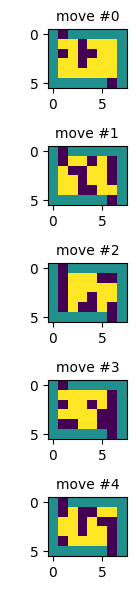

solution: 54


In [7]:
if __name__ == "__main__":
    LOGGER.setLevel(logging.DEBUG if SHOW_DEBUG_LOG else logging.INFO)
    log_formatter = logging.Formatter("%(message)s")
    log_handler = logging.StreamHandler(sys.stdout)
    log_handler.setFormatter(log_formatter)
    LOGGER.addHandler(log_handler)
    main()